# **9.4 Differentiation Infrastructure in Deepchem**

실제 물리현상들은 비선형 구조이므로 비선형 문제를 풀어야함

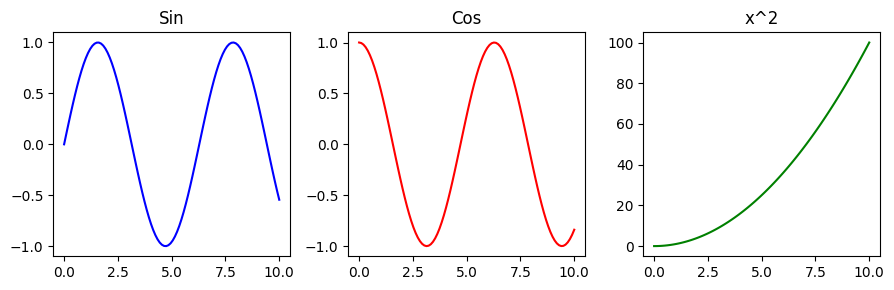

In [1]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0, 10, 100)
y1 = np.sin(x)
y2 = np.cos(x)
y3 = x**2

fig, axs = plt.subplots(1, 3, figsize=(9, 3))

axs[0].plot(x, y1, color='blue')
axs[0].set_title('Sin')

axs[1].plot(x, y2, color='red')
axs[1].set_title('Cos')

axs[2].plot(x, y3, color='green')
axs[2].set_title('x^2')

plt.tight_layout()

plt.show()

deepchem.utils.differentiation_utils.optimize.rootfinder

Broyden's First Method

1. 변수($X_k$)와 자코비안 근사치($J_k$)를 초기화.
2. 현재 위치에서의 함수값($f_k$)를 구함
3. $X_{k+1} = X_k - J_k^{-1} f_k$ 을 통해 변수 업데이트
4. 실제 변화량과 함수값을 비교하여  자코비안($J^{-1}$)을 갱신하고 수렴할때까지 반복

기존은 정답을 찾기위해 모든 변수의 변화량(Jacobian matrix)를 매번 계산 -> 계산량이 매우 많아 비효율적 -> Broyden은 Jacobian matrix를 근사적으로 업데이트

In [ ]:
import torch
!pip install deepchem
from deepchem.models.torch_models.layers import rootfinder
def func1(y, A):
    return torch.tanh(A @ y + 0.1) + y / 2.0
A = torch.tensor([[1.1, 0.4], [0.3, 0.8]]).requires_grad_()
y0 = torch.zeros((2,1))

# Broyden's First Method
yroot = rootfinder(func1, y0, params=(A,), method='broyden1')
print("Root By Broyden's First Method:")
print(yroot)
print("Function Value at Calculated Root:")
print(func1(yroot, A))

Broyden's Second Method

출력값의 차이인 잔차(Residual)의 변화를 기준으로 역행렬 갱신

$J^{-1}_{k+1} = J^{-1}_k + \frac{(\Delta X_{k+1} - J^{-1}_k \Delta f_{k+1}) \Delta f^T_{k+1}}{\Delta f^T_{k+1} \Delta f_{k+1}}$

함수값의 변화가 급격하거나 계산이 불안정할 때, 훨씬 더 Robust하게 정답을 찾아감

Classical Approach

$x_{k+1} = f(x_k)$ 단순하게 결과가 다음의 입력이 됨

Anderson Acceleration / Mixing

1. 지난 m개의 입력 x와 결과 f(x)를 모두 기억
2. 지난 결과들의 선형조합($\sum \alpha_j f_j$)이 잔차를 최소화하도록 가중치  $\alpha$ 구함
3. 단순히 $f(x_k)$로 가는게 아닌 과거의 성공적인 경로들 Mixing하여 점프
$x_{k+1} = \sum_{j=0}^{m_k} \alpha^k_j f(x_{k-m_k+j})$

In [ ]:
import torch
import matplotlib.pyplot as plt
from deepchem.utils.differentiation_utils.optimize.equilibrium import anderson_acc
x_value, f_value = [], []
def fcn(x, a):
    x_value.append(x.item())
    f_value.append((a/x + x).item()/2)
    return (a/x + x)/2
a = 2.0
x0 = torch.tensor([1.0], requires_grad=True)
x = anderson_acc(fcn, x0, params=[a], maxiter=16)
print("Root by Anderson Acceleration:", x.item())
print("Function Value at Calculated Root:", fcn(x, a).item())

# Plotting the convergence of Anderson Acceleration
plt.plot(x_value, label='Input Value')
plt.plot(f_value, label='Func. Value by Anderson Acce.')
plt.legend(loc='lower right')
plt.xlabel('Iteration')
plt.ylabel('Function Value')
plt.title('Convergence of Anderson Acceleration')
plt.show()

In [ ]:
import torch
from deepchem.utils.differentiation_utils.optimize.minimizer import gd
def fcn(x):
    return 2 * x + (x - 2) ** 2, 2 * (x - 2) + 2
x0 = torch.tensor(0.0, requires_grad=True)
x = gd(fcn, x0, [])
print("Minimum by Gradient Descent:", x.item())
print("Function Value at Calculated Minimum:", fcn(x)[0].item())

In [ ]:
import torch
from deepchem.utils.differentiation_utils.optimize.minimizer import adam
def fcn(x):
    return 2 * x + (x - 2) ** 2, 2 * (x - 2) + 2
x0 = torch.tensor(10.0, requires_grad=True)
x = adam(fcn, x0, [], maxiter=20000)
print("X at Minimum by Adam:", x.item())
print("Function Value at Calculated Minimum:", fcn(x)[0].item())

MInimizer

Gradient Descent: 현재 위치에서 기울기를 구해 그 반대방향으로 내려감

ADAM(Adaptive Moment Estimation): Gradient Descent에 Momentum과 학습률 자동 조절(RMSProp)를 합침(보정단계 포함)

💡 insight

Anderson Acceleration과 Broyden Method등 여러 최적화 기법을 인프라 내에 구축해 비선형 물리 방정식의 수렴 속도와 안정성 확보